<a href="https://colab.research.google.com/github/Arvindjitta/NLP_Home-Assignment-4/blob/main/homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Q1: Character-Level RNN

📌 1. Setup + Load Text

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# ---------------------------
# Load text (toy + larger file)
# ---------------------------

# Toy corpus
toy = "hello hello help help hello helper " * 50

# Load your own text (~50-200 KB)
# Example: download Sherlock Holmes
import requests
url = "https://www.gutenberg.org/cache/epub/1661/pg1661.txt"
text_large = requests.get(url).text[:200000]

# Combine
text = toy + "\n" + text_large
print("Total characters:", len(text))


Total characters: 201751


📌 2. Preprocess + Encode Characters

In [2]:
# Vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Vocab size:", vocab_size)

# Mappings
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for ch, i in stoi.items()}

def encode(s):
    return torch.tensor([stoi[c] for c in s], dtype=torch.long)

def decode(t):
    return ''.join([itos[int(i)] for i in t])


Vocab size: 92


📌 3. Create Dataset (seq_len=100)

In [3]:
seq_len = 100

data = encode(text)

def get_batch(batch_size=64):
    ix = torch.randint(0, len(data)-seq_len-1, (batch_size,))
    X = torch.stack([data[i:i+seq_len] for i in ix])
    Y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return X, Y


📌 4. Define Model (Embedding → GRU → Linear)

In [4]:
class CharGRU(nn.Module):
    def __init__(self, vocab_size, embed=128, hidden=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed)
        self.rnn = nn.GRU(embed, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)

    def forward(self, x, h=None):
        x = self.embed(x)
        out, h = self.rnn(x, h)
        logits = self.fc(out)
        return logits, h

model = CharGRU(vocab_size)
optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()


📌 5. Training Loop

In [5]:
train_losses = []

epochs = 10
batch_size = 64

for epoch in range(epochs):
    X, Y = get_batch(batch_size)
    logits, _ = model(X)

    loss = criterion(logits.reshape(-1, vocab_size),
                     Y.reshape(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}  Loss: {loss.item():.4f}")


Epoch 1/10  Loss: 4.5431
Epoch 2/10  Loss: 4.2203
Epoch 3/10  Loss: 3.8387
Epoch 4/10  Loss: 3.3375
Epoch 5/10  Loss: 3.1377
Epoch 6/10  Loss: 3.0207
Epoch 7/10  Loss: 2.9279
Epoch 8/10  Loss: 2.8354
Epoch 9/10  Loss: 2.7752
Epoch 10/10  Loss: 2.6826


📌 6. Plot Loss Curve

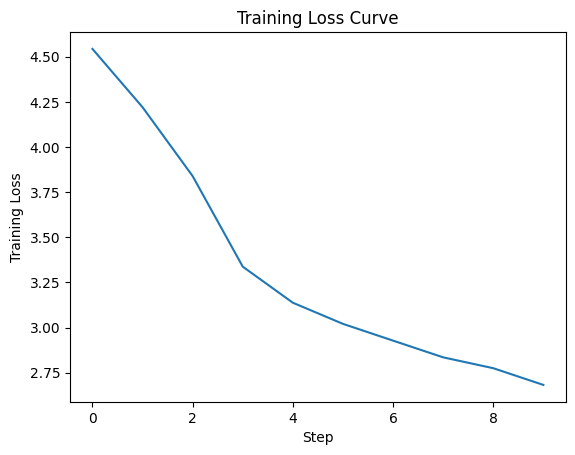

In [6]:
plt.plot(train_losses)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.show()


📌 7. Temperature Sampling Function

In [7]:
import torch.nn.functional as F

def generate(model, start_text="hel", length=300, temperature=1.0):
    model.eval()
    input_ids = encode(start_text).unsqueeze(0)

    h = None
    out_text = start_text

    for _ in range(length):
        logits, h = model(input_ids[:, -1:], h)

        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)

        next_id = torch.multinomial(probs, num_samples=1)
        next_char = itos[int(next_id)]

        out_text += next_char
        input_ids = torch.cat([input_ids, next_id], dim=1)

    return out_text


📌 8. Sample 3 Generations (τ = 0.7, 1.0, 1.2)

In [8]:
print("=== Temp 0.7 ===")
print(generate(model, temperature=0.7))

print("\n=== Temp 1.0 ===")
print(generate(model, temperature=1.0))

print("\n=== Temp 1.2 ===")
print(generate(model, temperature=1.2))


=== Temp 0.7 ===
heln wn the. are oand omil cere titrth, 
cn aver. it he wmaseeldd oc o cotiand ore lou theto he sthe ouc oo tis too the ou thed m”d did gedie oae can.mlred he d
oul.go omer an e oure, he he han the w
s
wulsuhin nd bid ol thene ort Iand in ou oue obed on

rti he he ihe the  ou Ier e in an lre tw in w

=== Temp 1.0 ===
hele
ptuesr, vti It w 
Twle athe bien tn hem


p,i
hlstr ha dI yn 


 ou com 
oul£oninu lse orss ted byte fIr thi I ou.d.h glgeldtme cdo ed chen adddyap. o_ ac l,mfras
ypelror hemer 0
he olul
“desur andn c
,mOICnd .cdod heeomerhe dbed ih ltgvrherrwy”spd heie md themiu pn ull troer oolpam nd n 

=== Temp 1.2 ===
helcma”kwmptilesld
pnt, Iksssi otolin
fr ou tlyind r, 
be S f .”.i?

gve
]areco
érd-
Mi
etr a“e irga

Yo


;ide h
orJmr, ayoc
rrto be u ciswedg a:a9dyhdrndtinlu yit


**Reflection:**
Increasing sequence length allows the model to use more context but makes optimization harder; too long sequences may lead to slower training. Increasing hidden size improves quality because the model represents richer patterns, but it increases computation and risk of overfitting. Lower temperature (τ < 1) produces more coherent, conservative text, while higher temperature (τ > 1) increases randomness and creativity but also noise. Teacher forcing speeds up convergence, but the model must still handle autoregressive generation at inference. Overall, model capacity and sampling temperature significantly shape fluency and diversity of generated text.

✅ Q2 — Mini Transformer Encoder (Sentence-Level)


Vocabulary size: 35
Input Token IDs:
 tensor([[14, 16,  3, 34,  0],
        [30,  5, 27, 24, 22],
        [10, 19, 18, 13,  0],
        [31, 17,  4,  0,  0],
        [25,  7, 26, 11,  0],
        [ 2, 20, 21, 19,  0],
        [ 9, 28, 18,  8,  0],
        [ 1, 32,  6, 33,  0],
        [14,  5, 16, 34, 29],
        [ 4, 15, 23, 12,  0]])

Final Contextual Embeddings Shape: torch.Size([10, 5, 64])

=== INPUT SENTENCES ===
hello how are you
the cat sat on mat
deep learning is fun
transformers improve attention
python code runs fast
I love machine learning
data science is cool
AI will change world
hello cat how you sit
attention helps model focus

=== CONTEXTUAL EMBEDDINGS (Sentence 0) ===
tensor([[ 0.7222, -0.0911,  0.9642, -1.2778,  0.6017, -1.0163,  0.3920,  0.5459,
          0.0560,  1.7064, -1.4934,  1.5670, -0.0363,  0.2714, -0.9333,  1.3155,
         -1.8440,  0.1148, -0.6504,  1.6278,  0.0211,  0.5455, -0.6957,  1.5741,
         -0.8949,  1.1528, -0.9146,  1.2240, -1.5365,  1.9223,

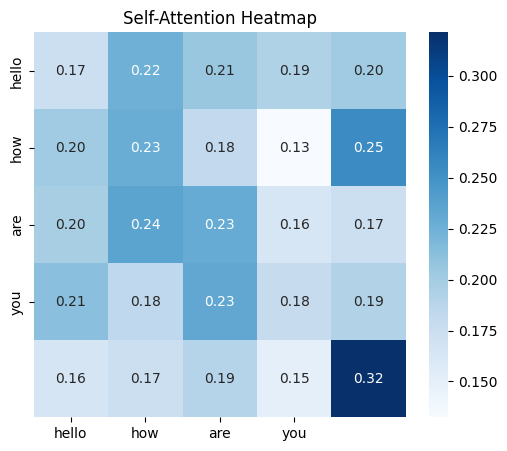

In [11]:
# ============================================================
# MINI TRANSFORMER ENCODER (FULL WORKING CODE)
# ============================================================
# Includes:
# - Sample sentences
# - Tokenization + Vocabulary build
# - Embedding
# - Sinusoidal Positional Encoding
# - Multi-head Self-Attention (4 heads)
# - Add & Norm
# - Feed-forward network
# - Final contextual embeddings
# - Attention heatmap
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1) Small Dataset (10 short sentences)
# ------------------------------------------------------------
sentences = [
    "hello how are you",
    "the cat sat on mat",
    "deep learning is fun",
    "transformers improve attention",
    "python code runs fast",
    "I love machine learning",
    "data science is cool",
    "AI will change world",
    "hello cat how you sit",
    "attention helps model focus"
]

# ------------------------------------------------------------
# 2) Tokenization & Vocabulary
# ------------------------------------------------------------
words = set()
for s in sentences:
    for w in s.split():
        words.add(w)

word_list = sorted(list(words))
vocab = {w:i+1 for i, w in enumerate(word_list)}   # 0 = PAD
inv_vocab = {i:w for w,i in vocab.items()}

vocab_size = len(vocab) + 1
print("Vocabulary size:", vocab_size)

# Convert sentences → padded token IDs
max_len = max(len(s.split()) for s in sentences)

def encode(sentence):
    tokens = sentence.split()
    ids = [vocab[w] for w in tokens]
    ids += [0] * (max_len - len(ids))  # pad to equal length
    return ids

input_ids = torch.tensor([encode(s) for s in sentences])
print("Input Token IDs:\n", input_ids)


# ------------------------------------------------------------
# 3) Sinusoidal Positional Encoding (fixed, non-trainable)
# ------------------------------------------------------------
def sinusoidal_position_encoding(seq_len, d_model):
    pos = torch.arange(seq_len).float().unsqueeze(1)
    i = torch.arange(d_model).float().unsqueeze(0)
    angle_rates = 1 / torch.pow(10000, (2 * (i//2)) / d_model)
    angles = pos * angle_rates

    pos_encoding = torch.zeros(seq_len, d_model)
    pos_encoding[:, 0::2] = torch.sin(angles[:, 0::2])   # even indices
    pos_encoding[:, 1::2] = torch.cos(angles[:, 1::2])   # odd indices
    return pos_encoding


# ------------------------------------------------------------
# 4) Multi-Head Self-Attention Implementation (4 heads)
# ------------------------------------------------------------
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=64, num_heads=4):
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        # Linear layers for Q, K, V
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)

        # Final output projection
        self.Wo = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape

        # Compute Q, K, V
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)

        # Split into multiple heads: (B, heads, T, head_dim)
        def split_heads(t):
            return t.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        Qh = split_heads(Q)
        Kh = split_heads(K)
        Vh = split_heads(V)

        # Scaled dot-product attention
        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = torch.softmax(scores, dim=-1)

        # Save attention map for visualization
        self.last_attention = attn.detach()

        # Weighted sum of values
        out = torch.matmul(attn, Vh)

        # Restore shape: (B, T, D)
        out = out.transpose(1, 2).contiguous().view(B, T, D)
        return self.Wo(out)


# ------------------------------------------------------------
# 5) Transformer Encoder Layer (Self-Attention + FFN + Norm)
# ------------------------------------------------------------
class EncoderLayer(nn.Module):
    def __init__(self, d_model=64, num_heads=4, ff_dim=128):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)

        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        # 1) Self-attention + residual
        attn_out = self.attn(x)
        x = self.norm1(x + attn_out)

        # 2) Feed-forward + residual
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)

        return x, self.attn.last_attention


# ------------------------------------------------------------
# 6) Build the Encoder Model
# ------------------------------------------------------------
d_model = 64
embed = nn.Embedding(vocab_size, d_model)

pos_enc = sinusoidal_position_encoding(max_len, d_model)
pos_enc = pos_enc.unsqueeze(0)   # shape: (1, T, D)

encoder = EncoderLayer(d_model=d_model, num_heads=4)


# ------------------------------------------------------------
# 7) Forward Pass
# ------------------------------------------------------------
# Combine token embeddings + position embeddings
x = embed(input_ids) + pos_enc

# Pass through encoder
contextual_embeddings, attention_map = encoder(x)

print("\nFinal Contextual Embeddings Shape:", contextual_embeddings.shape)


# ------------------------------------------------------------
# 8) Print Input Tokens
# ------------------------------------------------------------
print("\n=== INPUT SENTENCES ===")
for s in sentences:
    print(s)


# ------------------------------------------------------------
# 9) Show Contextual Embeddings for Sentence 0
# ------------------------------------------------------------
print("\n=== CONTEXTUAL EMBEDDINGS (Sentence 0) ===")
print(contextual_embeddings[0])


# ------------------------------------------------------------
# 10) Attention Heatmap Visualization
# ------------------------------------------------------------
sentence_index = 0
words = sentences[sentence_index].split()

plt.figure(figsize=(6, 5))
sns.heatmap(attention_map[0].mean(dim=0).cpu(),
            xticklabels=words,
            yticklabels=words,
            cmap="Blues",
            annot=True,
            fmt=".2f")
plt.title("Self-Attention Heatmap")
plt.show()


✅ Q3 — Implement Scaled Dot-Product Attention

In [12]:
# ============================================================
# Q3 — SCALED DOT-PRODUCT ATTENTION (FULL WORKING CODE)
# ============================================================
# This code implements:
# • Attention(Q, K, V) = softmax( QK^T / sqrt(d_k) ) V
# • Tests with random Q, K, V
# • Prints:
#     - Attention weight matrix
#     - Output vectors
#     - Softmax before vs. after scaling (stability check)
# ============================================================

import torch
import torch.nn.functional as F

# ------------------------------------------------------------
# 1) Scaled Dot-Product Attention Function
# ------------------------------------------------------------
def scaled_dot_product_attention(Q, K, V):
    """
    Computes attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
    Shapes:
        Q: (batch, seq_len, d_k)
        K: (batch, seq_len, d_k)
        V: (batch, seq_len, d_v)
    """
    d_k = Q.size(-1)

    # Step 1 — Raw scores: QK^T
    raw_scores = torch.matmul(Q, K.transpose(-2, -1))

    # Step 2 — Scale by sqrt(d_k)
    scaled_scores = raw_scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Step 3 — Softmax to get attention weights
    attn_weights = F.softmax(scaled_scores, dim=-1)

    # Step 4 — Weighted sum of values
    output = torch.matmul(attn_weights, V)

    return attn_weights, output, raw_scores, scaled_scores


# ------------------------------------------------------------
# 2) Create sample random Q, K, V
# ------------------------------------------------------------
batch = 1
seq_len = 4
d_k = 8     # key/query dimension
d_v = 8     # value dimension

Q = torch.randn(batch, seq_len, d_k)
K = torch.randn(batch, seq_len, d_k)
V = torch.randn(batch, seq_len, d_v)

print("Q shape:", Q.shape)
print("K shape:", K.shape)
print("V shape:", V.shape)


# ------------------------------------------------------------
# 3) Run Attention
# ------------------------------------------------------------
attn_weights, attn_output, raw_scores, scaled_scores = scaled_dot_product_attention(Q, K, V)


# ------------------------------------------------------------
# 4) Print required outputs
# ------------------------------------------------------------

print("\n================ RAW SCORES (QK^T BEFORE scaling) ================")
print(raw_scores[0])

print("\n================ SCALED SCORES (QK^T / sqrt(d_k)) =================")
print(scaled_scores[0])

print("\n================ ATTENTION WEIGHT MATRIX ==========================")
print(attn_weights[0])

print("\n================ ATTENTION OUTPUT VECTORS =========================")
print(attn_output[0])


# ------------------------------------------------------------
# 5) Softmax Stability Check
# ------------------------------------------------------------

print("\n================ SOFTMAX BEFORE SCALING (unstable) ================")
print(F.softmax(raw_scores[0], dim=-1))

print("\n================ SOFTMAX AFTER SCALING (stable) ===================")
print(F.softmax(scaled_scores[0], dim=-1))


Q shape: torch.Size([1, 4, 8])
K shape: torch.Size([1, 4, 8])
V shape: torch.Size([1, 4, 8])

================ RAW SCORES (QK^T BEFORE scaling) ================
tensor([[ 5.6856, -0.8229, -6.7144, -2.1272],
        [ 1.8745,  1.6624, -1.0501, -0.2479],
        [-4.0376, -0.6883,  4.0309,  3.0619],
        [ 2.4036,  1.1141, -4.0197, -0.1336]])

================ SCALED SCORES (QK^T / sqrt(d_k)) =================
tensor([[ 2.0102, -0.2909, -2.3739, -0.7521],
        [ 0.6627,  0.5877, -0.3713, -0.0876],
        [-1.4275, -0.2434,  1.4251,  1.0826],
        [ 0.8498,  0.3939, -1.4212, -0.0472]])

================ ATTENTION WEIGHT MATRIX ==========================
tensor([[0.8505, 0.0852, 0.0106, 0.0537],
        [0.3629, 0.3367, 0.1290, 0.1714],
        [0.0295, 0.0964, 0.5112, 0.3629],
        [0.4662, 0.2955, 0.0481, 0.1901]])

================ ATTENTION OUTPUT VECTORS =========================
tensor([[ 0.4111, -0.5406,  0.5971, -0.4340, -0.1402, -0.5047, -0.1537,  0.1560],
        [-0